In [40]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [41]:
# Enable GPU optimizations
tf.config.optimizer.set_jit(True)
tf.config.set_soft_device_placement(True)

In [42]:
# Constants
BATCH_SIZE = 4
IMG_HEIGHT, IMG_WIDTH = 128, 128
NUM_FRAMES = 32

In [43]:
def load_video_clips(directory, num_frames=NUM_FRAMES, img_height=IMG_HEIGHT, img_width=IMG_WIDTH):
    clips = []
    labels = []
    
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if not os.path.isdir(label_dir):
            continue
            
        for clip_folder in os.listdir(label_dir):
            clip_path = os.path.join(label_dir, clip_folder)
            if not os.path.isdir(clip_path):
                continue
                
            frames = []
            frame_files = sorted(os.listdir(clip_path))
            
            # Ensure we have enough frames
            if len(frame_files) < num_frames:
                continue
                
            for frame_name in frame_files[:num_frames]:
                frame_path = os.path.join(clip_path, frame_name)
                try:
                    frame = tf.keras.preprocessing.image.load_img(
                        frame_path, 
                        target_size=(img_height, img_width)
                    )
                    frame = tf.keras.preprocessing.image.img_to_array(frame) / 255.0
                    
                    # Verify frame shape
                    if frame.shape != (img_height, img_width, 3):
                        raise ValueError(
                            f"Invalid frame shape: {frame.shape}. "
                            f"Expected {(img_height, img_width, 3)}"
                        )
                    frames.append(frame)
                except Exception as e:
                    print(f"Error loading {frame_path}: {str(e)}")
                    continue
            
            if len(frames) == num_frames:
                clips.append(np.array(frames))
                labels.append(0 if label == 'non_accident' else 1)
    
    # Convert to numpy arrays and verify shapes
    clips_array = np.array(clips)
    labels_array = np.array(labels)
    
    print(f"Loaded {len(clips_array)} clips with shape {clips_array.shape}")
    print(f"Labels shape: {labels_array.shape}")
    
    return clips_array, labels_array

In [44]:
# Load data
print("Loading training data...")
X_train, y_train = load_video_clips('data/train')
print("\nLoading validation data...")
X_val, y_val = load_video_clips('data/val')
print("\nLoading test data...")
X_test, y_test = load_video_clips('data/test')

Loading training data...
Loaded 373 clips with shape (373, 32, 128, 128, 3)
Labels shape: (373,)

Loading validation data...
Loaded 79 clips with shape (79, 32, 128, 128, 3)
Labels shape: (79,)

Loading test data...
Loaded 82 clips with shape (82, 32, 128, 128, 3)
Labels shape: (82,)


In [45]:
# Model 1: EfficientNetV2 + LSTM
def create_efficientnet_model():
    base_model = applications.EfficientNetV2B0(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )
    base_model.trainable = False

    inputs = layers.Input(shape=(NUM_FRAMES, IMG_HEIGHT, IMG_WIDTH, 3))
    
    # Process each frame through EfficientNet
    x = layers.TimeDistributed(base_model)(inputs)
    
    # Reduce spatial dimensions before LSTM
    x = layers.TimeDistributed(layers.GlobalAveragePooling2D())(x)
    
    # Temporal processing
    x = layers.Bidirectional(layers.LSTM(64))(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

In [46]:
# Model 2: ResNet50 + 3D CNN
def create_resnet_model():
    base_model = applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )
    base_model.trainable = False

    inputs = layers.Input(shape=(NUM_FRAMES, IMG_HEIGHT, IMG_WIDTH, 3))
    x = layers.TimeDistributed(base_model)(inputs)
    
    # 3D CNN processing
    x = layers.Conv3D(128, (3, 3, 3), activation='relu')(x)
    x = layers.MaxPooling3D((2, 2, 2))(x)
    
    # Global pooling instead of LSTM
    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(512, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

In [47]:
def train_and_evaluate(models_dict):
    results = {}
    
    for name, model in models_dict.items():
        print(f"\n{'='*50}")
        print(f"Training {name}")
        print(f"Input shape: {model.input_shape}")
        print(f"Output shape: {model.output_shape}")
        
        callbacks = [
            EarlyStopping(patience=5, monitor='val_auc', mode='max', verbose=1),
            ModelCheckpoint(
                f"best_{name.lower()}.keras",
                save_best_only=True,
                monitor='val_auc',
                mode='max'
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.1,
                patience=3,
                verbose=1
            )
        ]
        
        try:
            history = model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=15,
                batch_size=BATCH_SIZE,
                callbacks=callbacks,
                verbose=1
            )
            
            # Evaluate on test set
            test_results = model.evaluate(X_test, y_test, verbose=0)
            
            results[name] = {
                'model': model,
                'history': history.history,
                'test_metrics': {
                    'loss': test_results[0],
                    'accuracy': test_results[1],
                    'auc': test_results[2]
                }
            }
            
            # Plot training history
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(history.history['auc'], label='Train AUC')
            plt.plot(history.history['val_auc'], label='Val AUC')
            plt.title(f'{name} AUC')
            plt.legend()
            
            plt.subplot(1, 2, 2)
            plt.plot(history.history['loss'], label='Train Loss')
            plt.plot(history.history['val_loss'], label='Val Loss')
            plt.title(f'{name} Loss')
            plt.legend()
            
            plt.tight_layout()
            plt.savefig(f'{name.lower()}_training.png')
            plt.show()
            
        except Exception as e:
            print(f"Error training {name}: {str(e)}")
            continue
    
    return results

In [48]:
# Initialize and train models
models_dict = {
    'EfficientNetV2_LSTM': create_efficientnet_model(),
    'ResNet50_3DCNN': create_resnet_model()
}


Verifying model input shapes:
EfficientNetV2_LSTM: expects (32, 128, 128, 3), data has (32, 128, 128, 3)
ResNet50_3DCNN: expects (32, 128, 128, 3), data has (32, 128, 128, 3)

Training EfficientNetV2_LSTM
Input shape: (None, 32, 128, 128, 3)
Output shape: (None, 1)
Epoch 1/15
94/94 [==============================] - 53s 497ms/step - loss: 0.7133 - accuracy: 0.4960 - auc: 0.4372 - val_loss: 0.6882 - val_accuracy: 0.5570 - val_auc: 0.4360 - lr: 1.0000e-04
Epoch 2/15
94/94 [==============================] - 50s 532ms/step - loss: 0.6996 - accuracy: 0.5228 - auc: 0.4952 - val_loss: 0.6882 - val_accuracy: 0.5570 - val_auc: 0.4377 - lr: 1.0000e-04
Epoch 3/15
94/94 [==============================] - 50s 535ms/step - loss: 0.6893 - accuracy: 0.5416 - auc: 0.5377 - val_loss: 0.6892 - val_accuracy: 0.5570 - val_auc: 0.4636 - lr: 1.0000e-04
Epoch 4/15
94/94 [==============================] - ETA: 0s - loss: 0.6880 - accuracy: 0.5550 - auc: 0.5085
Epoch 4: ReduceLROnPlateau reducing learning rate

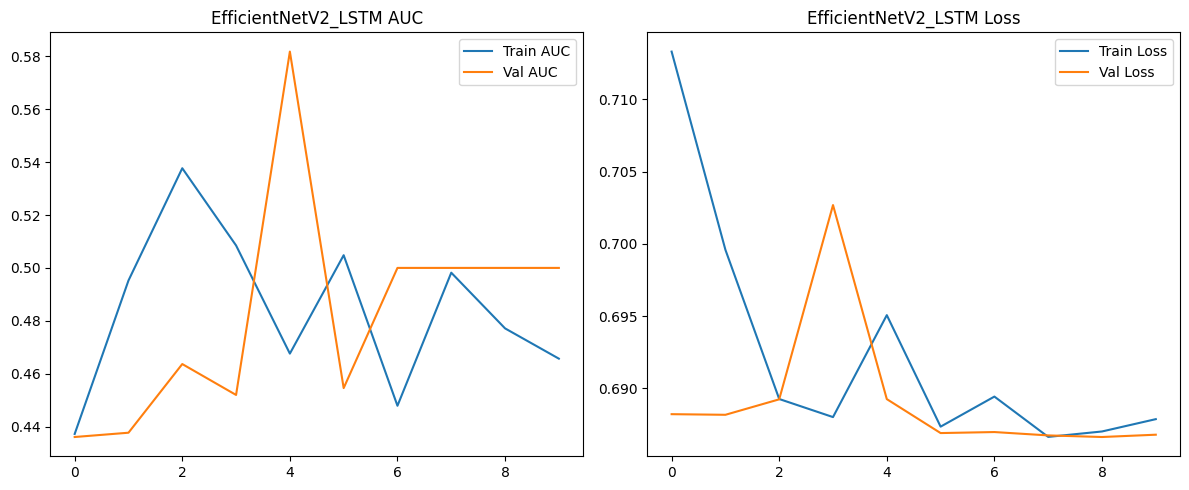


Training ResNet50_3DCNN
Input shape: (None, 32, 128, 128, 3)
Output shape: (None, 1)
Epoch 1/15
94/94 [==============================] - 127s 1s/step - loss: 0.7178 - accuracy: 0.5228 - auc: 0.5001 - val_loss: 0.6823 - val_accuracy: 0.5570 - val_auc: 0.6334 - lr: 1.0000e-04
Epoch 2/15
94/94 [==============================] - 137s 1s/step - loss: 0.6909 - accuracy: 0.5442 - auc: 0.5297 - val_loss: 0.7066 - val_accuracy: 0.4430 - val_auc: 0.7224 - lr: 1.0000e-04
Epoch 3/15
94/94 [==============================] - 120s 1s/step - loss: 0.6878 - accuracy: 0.5228 - auc: 0.5495 - val_loss: 0.6790 - val_accuracy: 0.6962 - val_auc: 0.7711 - lr: 1.0000e-04
Epoch 4/15
94/94 [==============================] - 120s 1s/step - loss: 0.6868 - accuracy: 0.5469 - auc: 0.5356 - val_loss: 0.6761 - val_accuracy: 0.5570 - val_auc: 0.7464 - lr: 1.0000e-04
Epoch 5/15
94/94 [==============================] - 120s 1s/step - loss: 0.6910 - accuracy: 0.5576 - auc: 0.5126 - val_loss: 0.6755 - val_accuracy: 0.5570

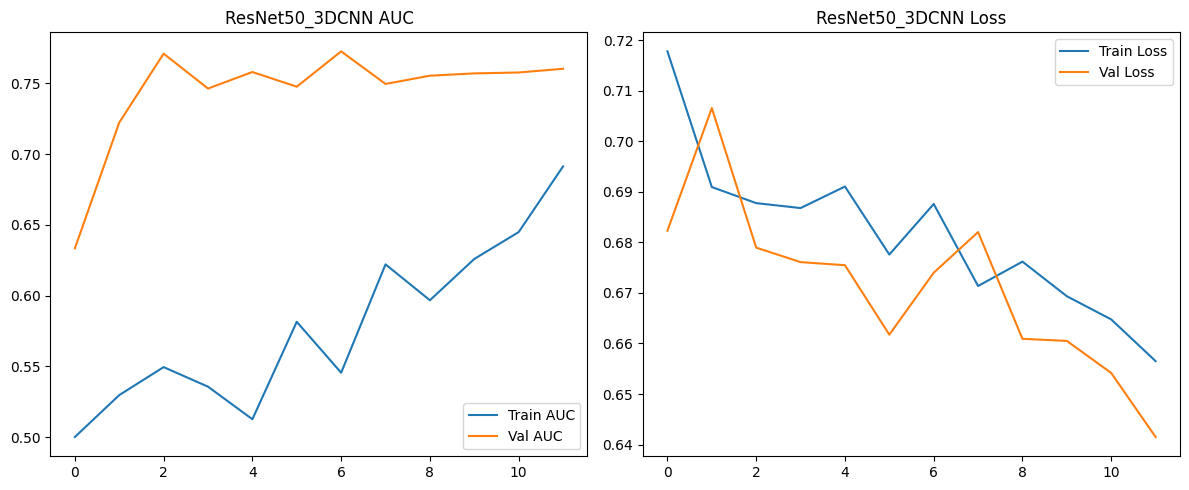


Best model: ResNet50_3DCNN
Test AUC: 0.7008
Test Accuracy: 0.6098
3/3 [==============================] - 19s 6s/step

Classification Report:
              precision    recall  f1-score   support

non_accident       0.64      0.25      0.36        36
    accident       0.60      0.89      0.72        46

    accuracy                           0.61        82
   macro avg       0.62      0.57      0.54        82
weighted avg       0.62      0.61      0.56        82



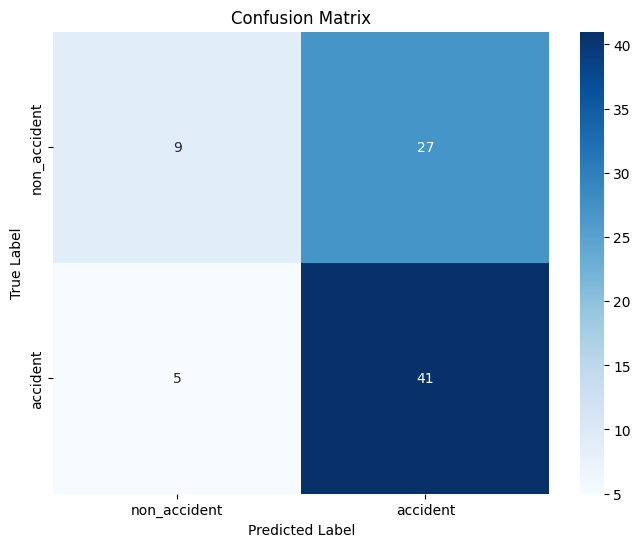

In [49]:
# Verify model input shapes match data
print("\nVerifying model input shapes:")
for name, model in models_dict.items():
    print(f"{name}: expects {model.input_shape[1:]}, data has {X_train.shape[1:]}")
    assert model.input_shape[1:] == X_train.shape[1:], \
        f"Shape mismatch for {name}"

# Train models
results = train_and_evaluate(models_dict)

# Select best model
if results:
    best_model_name = max(results, key=lambda x: results[x]['test_metrics']['auc'])
    best_model = results[best_model_name]['model']
    print(f"\n{'='*50}")
    print(f"Best model: {best_model_name}")
    print(f"Test AUC: {results[best_model_name]['test_metrics']['auc']:.4f}")
    print(f"Test Accuracy: {results[best_model_name]['test_metrics']['accuracy']:.4f}")
    
    # Save best model
    best_model.save(f"best_accident_model.keras")
    
    # Generate predictions
    y_pred = best_model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype(int)
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_classes, 
                              target_names=['non_accident', 'accident']))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['non_accident', 'accident'],
               yticklabels=['non_accident', 'accident'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix.png')
    plt.show()
else:
    print("No models were successfully trained")